In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lxml import etree
import pickle

In [9]:
# Make function to compare two series together:
def ppm_matrix(series1, series2):
    '''
    GOAL - create a matrix of pairwise ppm differences
    INPUT - 2 pandas Series, with index
    OUTPUT - dataframe with indexes containing pairwise ppm comparisons
        format: rows are series1 labels, columns are series2 labels    
    '''
    # do series1-series2 using numpy's broadcasting
    # This is faster than using a loop
    diff_matrix = abs(series1.values[:,np.newaxis] - series2.values)
    # Get max of pairwise comparisons
    max_matrix = np.maximum(series1.values[:,np.newaxis], 
                            series2.values)
    return (diff_matrix / max_matrix)*10**6


def pairwise_difference(series1, series2):
    '''
    GOAL - create matrix of pairwise differences
    INPUT - 2 pandas series, with index
    OUTPUT - dataframe, with indexes,
        format: columns are series1 labels, rows are series2 labels
    '''
    diff_matrix = abs(series1.values[:, np.newaxis] - series2.values)
    output = pd.DataFrame(diff_matrix,
                          index=series1.index,
                         columns=series2.index,
                         )
    return output


s1 = pd.Series({'A': 1, 'B':2}, dtype='float64')
s2 = pd.Series({'X':1, 'Y':2, 'Z':3},
              dtype='float64')

ppm_output = ppm_matrix(s1, s2)
print ppm_output
true_ppm_output = pd.DataFrame({'X':[0.0, (1/2.0)*10**6],
                            'Y':[(1/2.0)*10**6, 0.0],
                           'Z':[(2/3.0)*10**6, (1/3.0)*10**6]},
                          index=['A', 'B'], dtype='float64')

rt_output = pairwise_difference(s1,s2)
true_rt_output = pd.DataFrame({'X':[0.0, 1.0],
                              'Y':[1.0, 0.0],
                              'Z':[2.0, 1.0]},
                             index=['A', 'B'],
                             dtype='float64')

print 'ppm should be this:\n', true_ppm_output
print '\n\n Is it?\n', ppm_output

assert (ppm_output.all() == true_ppm_output.as_matrix().all()).all()
assert (rt_output.all() == true_rt_output.all()).all()

[[      0.          500000.          666666.66666667]
 [ 500000.               0.          333333.33333333]]
ppm should be this:
          X         Y              Z
A       0.0  500000.0  666666.666667
B  500000.0       0.0  333333.333333


 Is it?
[[      0.          500000.          666666.66666667]
 [ 500000.               0.          333333.33333333]]


<h2> Let's import a couple datasets and take them for a spin</h2>

In [10]:
### import two datasets
def reindex_xcms_by_mzrt(df):
    df.index = (df.loc[:,'mz'].astype('str') + 
               ':' + df.loc[:, 'rt'].astype('str'))
    return df


# alzheimers
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/'\
'projects'
alzheimers_path = local_path + '/revo_healthcare/data/processed/MTBLS72/positive_mode/'\
'mtbls_no_retcor_bw2.csv'
## Import the data and remove extraneous columns
df_alzheimers = pd.read_csv(alzheimers_path, index_col=0)
df_alzheimers = reindex_xcms_by_mzrt(df_alzheimers)
# malaria
malaria_path = local_path + ('/revo_healthcare/data/processed/MTBLS315/'+ 
            'uhplc_pos/xcms_result_4.csv')
df_malaria = pd.read_csv(malaria_path, index_col=0)
df_malaria = reindex_xcms_by_mzrt(df_malaria)
    

In [11]:
ppm_alz_v_malaria = ppm_matrix(df_malaria['mz'], 
                                   df_alzheimers['mz'])

rt_alz_v_malaria = pairwise_difference(df_malaria['rt'], 
                                          df_alzheimers['rt'])


<h2> Looks like There aren't too many ppm m/z overlaps </h2>

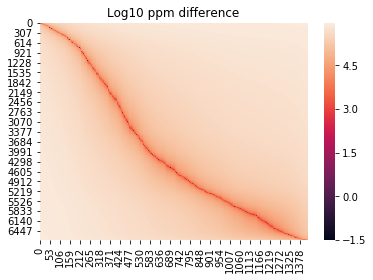

In [12]:
sns.heatmap(np.log10(ppm_alz_v_malaria))
plt.title('Log10 ppm difference')
plt.show()

In [13]:
# How many for differences at 30ppm?
ppm_window = 30
within_ppm = (ppm_alz_v_malaria[ppm_alz_v_malaria < 30]
                  .dropna(axis=0, how='all')
                  .dropna(axis=1, how='all')
             )
print 'shape', ppm_alz_v_malaria.shape
print ('ppm within {ppm} ppm: '.format(ppm=ppm_window) +
       '{num}'.format(num=(ppm_alz_v_malaria < 30).sum().sum()))

# Get indexes
print 'shape of htose within 30ppm:, ', within_ppm.shape


# How many m/z from one dataset could be m/z isomers from
# other dataset?
print ('\n\nMass matches between datasets (isomers and 1:1 matches)',
       (within_ppm < 30).sum().sum())

print '\nAlzheimers "isomers" in other dataset that are match >1 feature in other set', ((within_ppm < 30).sum(axis=0)>1).sum()
print 'Alzheimers total', df_alzheimers['rt'].shape


print '\n\nMalaria "isomers in other dataset that match >1 feature in other set', ((within_ppm < 30).sum(axis=1) > 1).sum()
print 'Malaria total', df_malaria['rt'].shape



AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

Axes(0.125,0.125;0.775x0.755)


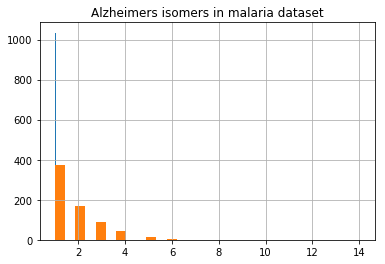

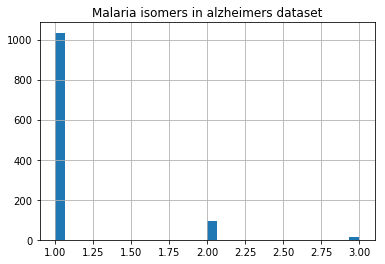

In [179]:
# Show distribution of # of isomers per feature in both malaria and fever datasets
print (within_ppm < 30).sum(axis=0).hist(bins=30)
plt.title('Alzheimers isomers in malaria dataset')
plt.show()

(within_ppm < 30).sum(axis=1).hist(bins=30)
plt.title('Malaria isomers in alzheimers dataset')
plt.show()

<h2> So, about 1/4 of the mass-matches have potential isomers in the other dataset...? </h2>
Notice how there are more matches to the malaria set, which has more peaks. Makes sense - more peaks either means more actual molecules, 
or more adducts that could be mistakenly matched as molecules

<h2> Get masses of all hmdb serum metabolites </h2>
parse the xml file

In [3]:
local = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
xml_file = local + 'revo_healthcare/data/external/toy_database.xml'
xml_file = local + 'revo_healthcare/data/external/serum_metabolites.xml'
#xml_tree = etree.iterparse(xml_file, tag='metabolite')
#



In [4]:
# namespace - at the top of file. fucks with every tag.
# very annoying, so name all tags ns + tag
ns = '{http://www.hmdb.ca}'
nsmap = {None : ns}
# If you're within a metabolite tag
count = 0
seen_mass = 0
d = {}
for event, element in etree.iterparse(xml_file, tag=ns+'metabolite'):
    tree = etree.ElementTree(element)
    # Aggregate info into a dictionary of 
    # {HMDB_ID: iso_mass}
    accession = []
    # Get accession number and masses for each metabolite
    # Could be multiple accessions. Grab all of them, 
    # sort to make unique identifier
    for elem in tree.iter():
        if elem.tag == ns+'accession':
            accession.append(elem.text)
        # If you just saw a 'mono_mass' entry,
        # get the mass value and reset, saying you
        # havent seen 'mono_mass' in the text of next metabolite
        if (elem.tag == ns+'value') & (seen_mass == 1): 
                mass = float(elem.text)
                seen_mass = 0
        if elem.text == 'mono_mass':
                seen_mass = 1
    elem.clear()
    
    # sort accession numbers and join with '_'    
    accession_key = '_'.join(sorted(accession))
    # add to dictionary
    if mass:
        d[accession_key] = mass
        
    # reset mass - only add feature if mass listed
    mass = None
    # reset accession numbers
    accession = []

    element.clear()
    count += 1
    if count % 1000 == 0:
        print('Made it through ' + str(count) + ' metabolites')

#pickle.dump(d, open('serumdb_dict.p', 'wb'))
print 'Number of metabolites: %s' % len(d.keys())

Made it through 1000 metabolites
Made it through 2000 metabolites
Made it through 3000 metabolites
Made it through 4000 metabolites
Made it through 5000 metabolites
Made it through 6000 metabolites
Made it through 7000 metabolites
Made it through 8000 metabolites
Made it through 9000 metabolites
Made it through 10000 metabolites
Made it through 11000 metabolites
Made it through 12000 metabolites
Made it through 13000 metabolites
Made it through 14000 metabolites
Made it through 15000 metabolites
Made it through 16000 metabolites
Made it through 17000 metabolites
Made it through 18000 metabolites
Made it through 19000 metabolites
Made it through 20000 metabolites
Made it through 21000 metabolites
Made it through 22000 metabolites
Made it through 23000 metabolites
Made it through 24000 metabolites
Made it through 25000 metabolites
Number of metabolites: 25310


In [5]:
serumdb_masses = pd.Series(d, dtype='float32')

In [7]:
serumdb_ppm_matrix = ppm_matrix(serumdb_masses, serumdb_masses)*10**6

In [10]:
#df = pd.DataFrame(serumdb_ppm_matrix, index=serumdb_masses.index,
#            columns=serumdb_masses.index)*10**6
# Forget about using a dataframe - uses too much memory

<h2> So, we've got 6,315,000 pairs of molecules that could be isomers at 1 ppm </h2>
That's about 10% of possible pairs from 25,000 molecules

In [23]:
top_ppm = 30
pairs = np.full((top_ppm), np.nan)
print(pairs)
for i in range(1,top_ppm):
    # div by two, b/c half matrix is redundant
    # subtract length of diagonal of matrix, too
    num = ((serumdb_ppm_matrix < i).sum() / 2) - serumdb_ppm_matrix.shape[0]
    pairs[i] = num

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


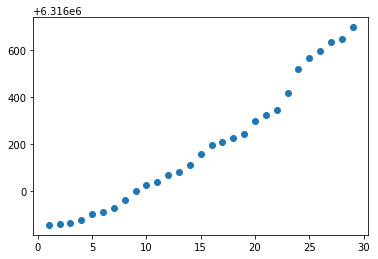

In [29]:
plt.scatter(x=range(1,30), y=pairs[1:])
plt.title('Number of pairs of molecules that could overlap in human serum database\n')
plt.show()

<h2> Looks like there are more isomers than 1:1 pairings, by a lot </h2>
Less than 6000 of 

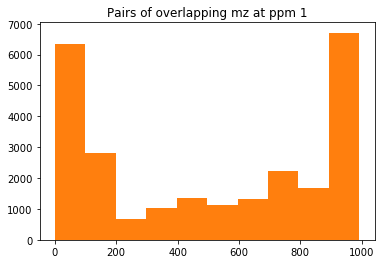

In [37]:
# how to plot the number of overlaps per molecule?
num_below_1ppm = (serumdb_ppm_matrix < 1).sum(axis=1) - 1
plt.hist((serumdb_ppm_matrix < 1).sum(axis=1) - 1 )
plt.title('Pairs of overlapping mz at ppm 1')
plt.show()

In [38]:
num_below_1ppm

array([  1,   1,   1, ..., 907,   2,   0])